In [1]:
# Data processing/formatting
from sklearn.preprocessing import MinMaxScaler
from seqprops import SequentialPropertiesEncoder
from sklearn.model_selection import train_test_split
from tools12 import one_hot_encode_list, one_hot_decode_list, one_hot_decode, softmax_beta

# for building vae model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D, Dropout, RepeatVector, TimeDistributed, Lambda, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# classic required packages
import os
import random
import pandas as pd
import numpy as np
from pylab import rcParams
import importlib
import importlib.resources

# packages for graphics
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard

In [2]:
file = 'amp.csv'
df = pd.read_csv(file)

# Filter the DataFrame to include only rows where the 'sequence' column has a length <= 12
df = df[df['sequence'].str.len() <= 12]

peptides = df.loc[:, 'sequence'].values
peptides_type = df.loc[:, 'label'].values
print(peptides)
print(peptides_type)

# Determine the length of the longest sequence
max_peptide_len = 0
for peptide in peptides:
    max_peptide_len = max(len(peptide), max_peptide_len)
print("Max peptide length: ", max_peptide_len)
print("Number of peptides where sequence is max 12 length", len(peptides))

['GEP' 'QHP' 'YLRF' ... 'TYKKPPFNGSIF' 'WKSYVRRWRSRY' 'YCNRRTGKCQRM']
[0 0 0 ... 0 1 1]
Max peptide length:  12
Number of peptides where sequence is max 12 length 1084


In [3]:
df['label'].value_counts()

0    707
1    377
Name: label, dtype: int64

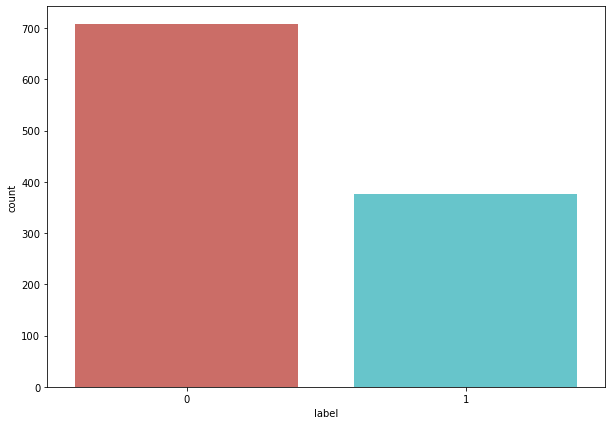

<Figure size 720x504 with 0 Axes>

In [4]:
rcParams['figure.figsize'] =  10,7
sns.countplot(x = 'label', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [5]:
np.set_printoptions(threshold=10000)
# Filter the DataFrame to include only rows where the 'sequence' column has a length <= 12 and label is 1
filtered_df = df[(df['sequence'].str.len() <= 12) & (df['label'] == 1)]

# Extract the 'sequence' column values from the filtered DataFrame
peptides = filtered_df['sequence'].values
peptides_type = filtered_df['label'].values

# Duplicate the peptides with label 1
duplicated_peptides = list(peptides)  # Create a list of duplicated peptides

# Create a list of scrambled peptides (same length as the duplicated peptides)
scrambled_peptides = ["".join(random.sample(peptide, len(peptide))) for peptide in duplicated_peptides]

# Create a DataFrame for the scrambled peptides with label 0
scrambled_df = pd.DataFrame({'sequence': scrambled_peptides, 'label': [0] * len(scrambled_peptides)})

# Create a new DataFrame for non-scrambled peptides with label 1 and max length 12
non_scrambled_df = df[(df['sequence'].str.len() <= 12) & (df['label'] == 1)]

# Concatenate the non-scrambled and scrambled DataFrames
result_df = pd.concat([non_scrambled_df, scrambled_df], ignore_index=True)

# Determine the length of the longest sequence among the filtered values
max_peptide_len = max(len(peptide) for peptide in peptides)
print("Max peptide length:", max_peptide_len)

# Verify the resulting DataFrame
# print(result_df)

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Print the entire result_df DataFrame
# print(result_df)

# Reset display options to their default values if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# Extract the 'sequence' column values from the filtered DataFrame
peptides = result_df['sequence'].values
peptides_type = result_df['label'].values

print(len(peptides))
print(peptides)

Max peptide length: 12
754
['LLEL' 'LLLE' 'RWRW' 'ACSAG' 'FPPWF' 'FPPWM' 'FVHPM' 'AMVGT' 'WLLKW'
 'QWGGG' 'IIGGR' 'WLKKW' 'FITVH' 'FPPWE' 'FPPWL' 'AMVSS' 'KWWWRW' 'RKKWFW'
 'RWRWRW' 'TWWRWW' 'KPPWRL' 'DPWDWV' 'RKTWFW' 'KPWERE' 'RRWWRF' 'WAIVLL'
 'RRYYRF' 'RKWLFW' 'KWRWIW' 'RKWHFW' 'KKWWKF' 'FVPIWM' 'HSPGGA' 'ATQSHQ'
 'TVYTNA' 'TVVTNA' 'RRWWWR' 'RRWFWR' 'DEDLDE' 'TVVTQA' 'LPPWIG' 'TVYTQA'
 'RRAARF' 'RRWWFR' 'KPWERL' 'KWKWKW' 'WRWFIH' 'FPPWVL' 'KIIKVVK' 'YQCGQGG'
 'GPIPWQR' 'IYEPEIA' 'KVFLGLK' 'KWLLKWL' 'CLAIGRR' 'LLDVLLE' 'GDDDDDD'
 'LKLLKKL' 'DDDDDDD' 'MRTGNAD' 'GSEIQPR' 'YAFGYPS' 'YMFHLMD' 'MRTGNAN'
 'LLKWLKK' 'VISIIPV' 'KWLKKWL' 'VPPIGWF' 'GADDDDD' 'QPWLPFR' 'LLKWLLK'
 'FPWWWPF' 'HPQYNQR' 'KLLKWLLK' 'WFRKQLKW' 'APRKQLKW' 'RIWVIWRR'
 'PFKISIHL' 'KLKLLLLL' 'RIWVIRWR' 'LFRKQLKW' 'ASILTNAS' 'HCLAIGRR'
 'QPFSLERW' 'RYPAVGYT' 'LLKWLKKL' 'TGVAWRIT' 'APRRQLKW' 'VRPYLVAF'
 'WKSYVRRW' 'TCSYTMEA' 'KIWVIRWR' 'KWKLFKKI' 'APRKNVRW' 'APRKNLKW'
 'APRKNVKW' 'RWRWRWRW' 'RPPGFSPF' 'RRWVIWRR' 'KYGDVPLY'

In [6]:
result_df['label'].value_counts()

0    377
1    377
Name: label, dtype: int64

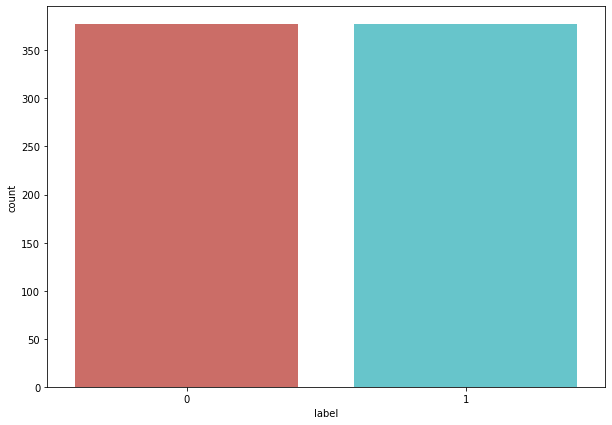

<Figure size 720x504 with 0 Axes>

In [7]:
rcParams['figure.figsize'] =  10,7
sns.countplot(x = 'label', data=result_df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [8]:
x_train_onehotencoded = one_hot_encode_list(peptides)
x_train_onehotencoded = x_train_onehotencoded.reshape((754, 12, 21))
print(x_train_onehotencoded.shape)

onehotencode_shape = x_train_onehotencoded.shape[1:]
print(onehotencode_shape)

(754, 12, 21)
(12, 21)


In [9]:
# Function for plotting latent space from encoded test data
def plot_input_data(encoder, x_data, y_data, title):
    z_input, _ = encoder.predict(x_data)
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'orange']
    
#     unique_labels = [0]
#     label_colors = ['blue']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title(title)
    plt.legend()
    plt.show()

In [10]:
# Function for plotting latent space from reconstructed decoder data
def plot_reconstructed_data(encoder, decoder, x_data, y_data, title):
    z_input, _ = encoder.predict(x_data)
    reconstructed_input = decoder.predict(z_input)
    reconstruced_z_input, _ = encoder.predict(reconstructed_input)
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(reconstruced_z_input[indices, 0], reconstruced_z_input[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title(title)
    plt.legend()
    plt.show()
    
title_enc_training_data = "Podaci za trening enkodirani u latentni prostor"
title_enc_test_data = "Podaci za test enkodirani u latentni prostor"
title_recon_enc_training_data = "Rekonstruirani trening podaci enkodirani u latentni prostor"
title_recon_enc_test_data ="Rekonstruirani testni podaci enkodirani u latentni prostor"

In [11]:
def create_seq_encoder_model(input_shape, latent_dim=2, lstm_cells=128):
    inp = Input(shape=input_shape, name="input_1_enc")
    x = LSTM(lstm_cells, unroll=True, name="lstm_enc")(inp)
    z = Dense(32, activation='relu', name="output_dense_enc")(x)
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
    
    encoder_model = Model(inputs=inp, outputs=[z_mean, z_log_sigma], name="encoder")
    return encoder_model

In [12]:
def create_seq_decoder_model(input_shape, latent_dim=2, lstm_cells=128):
    model_input = Input(shape=(latent_dim,), name="input_1_dec")
    x = RepeatVector(input_shape[0])(model_input)
    x = LSTM(lstm_cells, unroll=True, name="lstm_dec", return_sequences=True)(x)
    out = TimeDistributed(Dense(input_shape[1]))(x)
#    softmax
    last_dense = Activation(softmax_beta)(out)
    
    decoder_model = Model(inputs=model_input, outputs=last_dense, name="decoder")
    return decoder_model

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder     
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_seed(self, seed):
        self.random_seed = seed
        tf.random.set_seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        random.seed(seed)
    
    # Sampling from latent space
    def sampling(self, args):
        z_mean, z_log_sigma = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma = self.encoder(data)
            z = Lambda(self.sampling)([z_mean, z_log_sigma])
            reconstruction = self.decoder(z)
            
#             kl_loss =  tf.keras.backend.get_value(self.beta_x) * -1 * tf.reduce_mean(
#                 tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1)
#             )
            
            kl_loss = -0.01 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1)
            )
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=1
                )
            )
            
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x = data[0]
        z_mean, z_log_sigma = self.encoder(data)
        z = Lambda(self.sampling)([z_mean, z_log_sigma])
        reconstructed_x = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1)
            )

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(data, reconstructed_x), axis=1
            )
        )
        total_loss = reconstruction_loss + (kl_loss * 1000)
        self.compiled_metrics.update_state(x, reconstructed_x)

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results

In [14]:
encoder = create_seq_encoder_model(input_shape=onehotencode_shape)
encoder.summary()
decoder = create_seq_decoder_model(input_shape=onehotencode_shape)
decoder.summary()
vae = VAE(encoder, decoder)
vae.set_seed(31)

# callback = LossCallback(vae)
vae.compile(optimizer=keras.optimizers.Adam())

# tensorboard --logdir=C:\Users\StarLord\Documents\Diplomski\VAEs\tmp\onehot-vae\
# TensorBoard(log_dir='C:\\Users\\StarLord\\Documents\\Diplomski\\VAEs\\tmp\\onehot-vae')

# Thrid VAE model - with one-hot encoded data randomized data
# x_train_onehotencoded, x_test_onehotencoded, y_train_peptide_types, y_test_peptide_types
es = EarlyStopping(patience=10, verbose=1, min_delta=0.01, monitor='loss', mode='auto', restore_best_weights=True)
vae.fit(x_train_onehotencoded, batch_size=128, epochs=100, validation_split=0.2, 
        shuffle=False,
        callbacks=[es])

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_enc (InputLayer)       [(None, 12, 21)]     0           []                               
                                                                                                  
 lstm_enc (LSTM)                (None, 128)          76800       ['input_1_enc[0][0]']            
                                                                                                  
 output_dense_enc (Dense)       (None, 32)           4128        ['lstm_enc[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 2)            66          ['output_dense_enc[0][0]']       
                                                                                            

Epoch 27/100
5/5 [==============================] - 0s 57ms/step - loss: 1.7155 - reconstruction_loss: 1.7591 - kl_loss: 0.0303 - val_total_loss: 1337.2725 - val_reconstruction_loss: 0.5449 - val_kl_loss: 1.3367
Epoch 28/100
5/5 [==============================] - 0s 51ms/step - loss: 1.7128 - reconstruction_loss: 1.7539 - kl_loss: 0.0327 - val_total_loss: 1471.9479 - val_reconstruction_loss: 0.5454 - val_kl_loss: 1.4714
Epoch 29/100
5/5 [==============================] - 0s 56ms/step - loss: 1.7110 - reconstruction_loss: 1.7521 - kl_loss: 0.0333 - val_total_loss: 1517.3823 - val_reconstruction_loss: 0.5429 - val_kl_loss: 1.5168
Epoch 30/100
5/5 [==============================] - 0s 62ms/step - loss: 1.7059 - reconstruction_loss: 1.7471 - kl_loss: 0.0329 - val_total_loss: 1593.6331 - val_reconstruction_loss: 0.5420 - val_kl_loss: 1.5931
Epoch 31/100
5/5 [==============================] - 0s 52ms/step - loss: 1.7048 - reconstruction_loss: 1.7468 - kl_loss: 0.0334 - val_total_loss: 1738.8

24/24 [==============================] - 1s 4ms/step


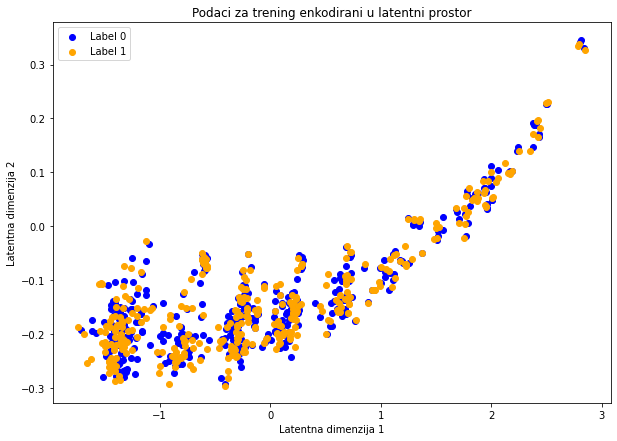

24/24 [==============================] - 0s 4ms/step


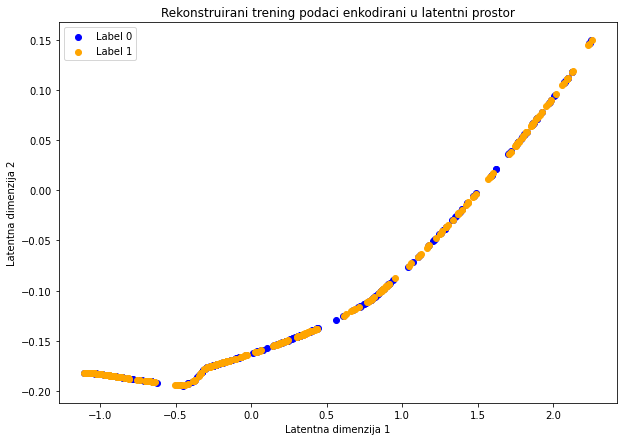

In [15]:
# x_train_onehotencoded, x_test_onehotencoded, y_train_peptide_types, y_test_peptide_types
# train data in latent space
plot_input_data(vae.encoder, x_train_onehotencoded, peptides_type, title_enc_training_data)
# reconstructed train data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, x_train_onehotencoded, peptides_type, title_recon_enc_training_data)

In [16]:
enc_pred, _ = vae.encoder.predict(x_train_onehotencoded)
decoded_data = vae.decoder.predict(enc_pred)

print(decoded_data)

# Loop through all amino acid position
decoded_data_peptide = []
decoded_data_peptides = []
for sequence_array in decoded_data:
    for seq in sequence_array:
        closest_to_1_index = np.argmax(np.abs(seq))
        binary_sequence = np.zeros_like(seq)
        binary_sequence[closest_to_1_index] = 1
        decoded_data_peptide.append(binary_sequence)
        converted = np.array(decoded_data_peptide)
        # [0,0,0,0,1]         
    decoded_data_peptides.append(converted) 
    # [[0,0,1], [0,0,1]]     
    decoded_data_peptide = []

final = one_hot_decode_list(decoded_data_peptides)
print(final)
print(len(final))

24/24 [==============================] - 0s 4ms/step
[[[4.69962172e-02 3.77431624e-02 4.60498445e-02 ... 7.29483664e-02
   3.89743373e-02 5.08306995e-02]
  [4.41571884e-02 2.96585578e-02 4.29085158e-02 ... 1.05747014e-01
   3.17810029e-02 5.67593910e-02]
  [3.95586304e-02 2.13127546e-02 3.54972035e-02 ... 1.55242249e-01
   2.32712626e-02 6.83595017e-02]
  ...
  [4.55348694e-04 1.49620886e-04 4.16197981e-05 ... 1.05649245e-03
   8.44727765e-05 9.87212121e-01]
  [4.44305188e-04 1.46480801e-04 4.01864527e-05 ... 1.01867004e-03
   8.22645743e-05 9.87506390e-01]
  [4.41667624e-04 1.45756567e-04 3.98287084e-05 ... 1.00929709e-03
   8.17539185e-05 9.87581491e-01]]

 [[4.70027551e-02 3.77616994e-02 4.60481495e-02 ... 7.28831738e-02
   3.89916301e-02 5.08219637e-02]
  [4.41753715e-02 2.96951104e-02 4.29194830e-02 ... 1.05555691e-01
   3.18174623e-02 5.67309707e-02]
  [3.95980999e-02 2.13623848e-02 3.55343707e-02 ... 1.54849470e-01
   2.33250186e-02 6.82861134e-02]
  ...
  [4.55435133e-04 1.4965